##### Copyright 2023 Melchor Lafuente Duque

# FILTERING THE SIGNAL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import scipy.io.wavfile as wavfile
import scipy.fftpack as sp
import scipy.signal as s
import cupy as cp
from PIL import Image
import imageio.v2 as imageio
import os

# Functions to read and write wav, txt and npy files

In [2]:
def read_wav(file_name, dir_name_input = "INPUT"):
    file_location = join(dir_name_input, file_name + ".wav")
    sample_rate, signal = wavfile.read(file_location)
    
    # If the signal is stereo, we transform it to mono:
    if signal.ndim > 1:
        left_channel = signal[:, 0]
        right_channel = signal[:, 1]
        signal = np.mean([left_channel, right_channel], axis=0)   
        
    return sample_rate, signal

def write_wav(file_name, sr, signal, output_dir_name = "OUTPUT"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    file_name_output = os.path.join(output_path, file_name + ".wav")
    wavfile.write(file_name_output, sr, signal.astype('int16'))

In [3]:
def write_txt(output_dir_name, signal_name, filename, data, data_type = '%d'):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".txt")
    np.savetxt(filename_output, [data], fmt = data_type)

In [4]:
def write_npy(output_dir_name, signal_name, filename, data):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".npy")
    np.save(filename_output, data)

## Plotting functions

We define the GPU device that we are going to use, in my case, I have three devices that I could use. So I will use one that is not being used by the previous process, the number three for example:

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3" #0,1,2,3

We define functions to plot the signals:

In [6]:
def plot_signal(sr, signal, file_name, file_suffix = "wav"):
    # Compute time axis in seconds
    time = np.arange(len(signal)) / float(sr)
    duration = time.max()

    # Plot audio signal
    fig, ax = plt.subplots()

    ax.plot(time, signal)
    
    # Add a title and axis labels
    file_location = join(file_name + "." + file_suffix)
    
    ax.set_title(file_location)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (A)")

    plt.show()

In [7]:
def plot_freq_array(freq_array):
    print("The image below has a dimension of: ", freq_array.T.shape)

    # Display the frequency domain image
    fig, ax = plt.subplots(figsize=(18, 3))
    ax.imshow(freq_array.T, aspect='auto', origin='lower')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Time (segment index)')
    fig.show()

## Reconstructed signal:

In [8]:
sample_rate = np.loadtxt(join("OUTPUT_1", "ORIGINAL_sample_rate.txt"), dtype=int)
n_samples = np.loadtxt(join("OUTPUT_1", "ORIGINAL_n_samples.txt"), dtype=int)

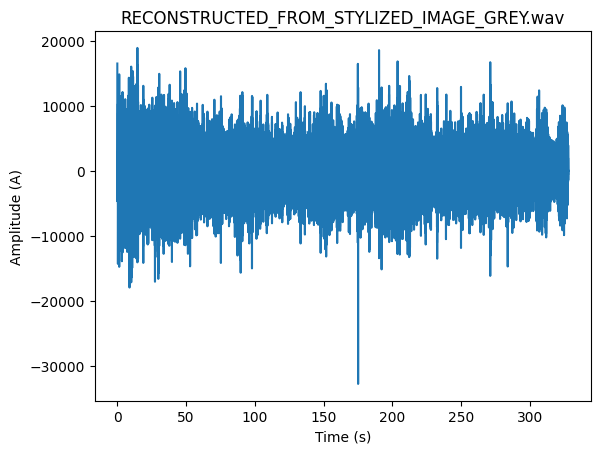

In [9]:
sample_rate_2, reconstructed_signal = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_2, reconstructed_signal, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY", file_suffix = "wav")

## Correlation and Squared Error

The **cross-correlation** is a measure of similarity between two signals based on their overlap and relative displacement. Thus, we are going to use this the measure to quantify how good the reconstruction was, comparing the original signal with its reconstruction: 

In [10]:
def correlation_normalized(signal_1, signal_2):
    signal_1_f = signal_1.astype('float64')
    signal_2_f = signal_2.astype('float64')
    
    x_gpu = cp.asarray(signal_1_f)
    y_gpu = cp.asarray(signal_2_f)
    
    corr_gpu = cp.correlate(x_gpu, y_gpu, mode='valid')
    corr_np = cp.asnumpy(corr_gpu)
    
    return corr_np/np.sqrt(np.sum(np.square(signal_1_f)) * np.sum(np.square(signal_2_f)))

<br>If the correlation is 1 then, good news! the signals are exactly the same, if the correlation is -1, then, the signals are exactly opposite to each other. Since we've somehow merged the original song with the Vincent Van Gogh's painting, it makes sense that the reconstructed song doesn't have much to do with the original:
<br>
<br>

In [11]:
_ , original_signal = read_wav(file_name = "NCS", dir_name_input = "INPUT")
corr_from_image = correlation_normalized(original_signal, reconstructed_signal)
corr_from_image

/tmp/ipykernel_321319/2744461553.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, signal = wavfile.read(file_location)


array([0.30541627])

<br>
We can also use the squared error to try to determine how much information we lose in the process. This measurement does not give us much information, unless we are comparing different signal differences. This way, if we are using a filter on the reconstructed signal to try to improve it, we can see how much it has improved by comparing its squared error against the unfiltered signal.
<br>
<br>

In [12]:
def se_signals(signal_1, signal_2):
    return (np.sum(np.square(signal_1.astype('float64') - signal_2.astype('float64'))))

In [13]:
# SE = Square Error (This metric doesn't give info at all: With big scales is difficult to understand the meaning)
se = se_signals(original_signal, reconstructed_signal)
se

906375958468085.5

## Bandpass 20 Hz - 20 KHz

Since human perception is only capable of hearing frequencies between 20 Hz and 20 KHz, we can try applying a bandpass filter within this range. By this way, maybe the correlation between the original signal and the reconstructed one improves because we are avoiding some noise that could have been created during the DCT.

In [14]:
def obtain_filters(sample_rate, freqs, N = 4):
    low_freq, high_freq = freqs
    nyquist_freq = 0.5 * sample_rate 

    #Cutoff frequencies bellow low_freq
    low_cutoff_freq = low_freq / nyquist_freq

    #Cutoff frequencies over high_freq
    high_cutoff_freq = high_freq / nyquist_freq

    b, a = s.butter(N, [low_cutoff_freq, high_cutoff_freq], 'bandpass')
    return b, a

def filter_signal(b, a, signal):
    return s.filtfilt(b, a, signal).astype("int16")

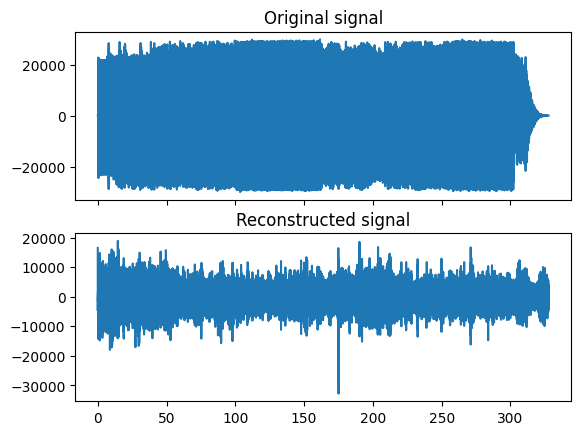

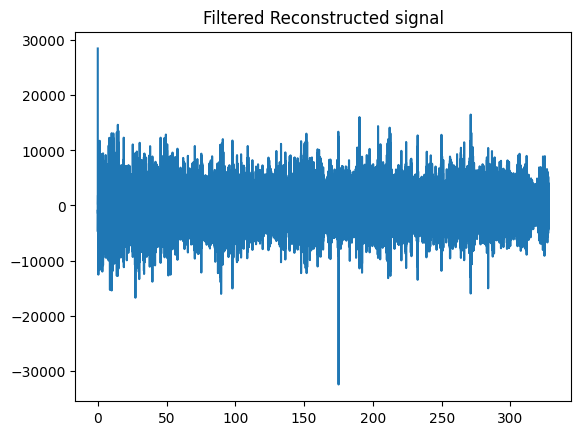

In [15]:
b, a = obtain_filters(sample_rate_2, [20, 20000])#s.butter(4, [low_cutoff_freq, high_cutoff_freq], 'bandpass')
filtered_reconstructed_signal = filter_signal(b, a, reconstructed_signal)

time = np.arange(n_samples) / float(sample_rate)

fig, (ax_orig, ax_filt) = plt.subplots(2, 1, sharex=True)
ax_orig.plot(time, original_signal)
ax_orig.set_title('Original signal')

ax_filt.plot(time, reconstructed_signal)
ax_filt.set_title('Reconstructed signal')
plt.show()

plt.plot(time, filtered_reconstructed_signal)
plt.title('Filtered Reconstructed signal')
plt.show()

In [16]:
corr_from_image_2 = correlation_normalized(original_signal, filtered_reconstructed_signal)
corr_from_image_2[0]

0.3112937660917197

In [17]:
# Create a list of tuples containing the table data
data = [
    ("\noriginal signal & reconstruction from image", str(corr_from_image)),
    ("\noriginal signal & reconstruction from image (20Hz-20KHz)", "\033[1m{}\033[0m".format(corr_from_image_2))
]

# Print the table headers
print("{:<80} {:<10}".format("Case", "Correlation"))
print("-" * 100)

# Print the table data
for row in data:
    print("{:<80} {:<10}".format(*row))

Case                                                                             Correlation
----------------------------------------------------------------------------------------------------

original signal & reconstruction from image                                     [0.30541627]

original signal & reconstruction from image (20Hz-20KHz)                        [0.31129377]


# Saving wav filtered

In [18]:
# # Write the reconstructed signal to a new .wav file
write_wav("RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_AND_FILTERED", sample_rate, filtered_reconstructed_signal, output_dir_name = "OUTPUT_4")

<br>
We can check if we have saved the audio file correctly simply by comparing the correlation between this audio and the one which we used to create it:

In [19]:
_ , filtered_reconstructed_signal_2 = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_AND_FILTERED", dir_name_input = "OUTPUT_4")

If the result is "1" we did it correctly:

In [20]:
correlation_normalized(filtered_reconstructed_signal, filtered_reconstructed_signal_2)

array([1.])

## Analyzing different frequency domains

We can filter the reconstructed signal, applying bandpass filters to see in which frequencies it loses more information:

In [21]:
# https://www.headphonesty.com/2020/02/audio-frequency-spectrum-explained/
AF = dict([('sub_bass',[16, 60]),('bass',[60,250]),('low_mids',[250,500]),('mids',[500, 2000]),('high_mids',[2000,4000]),('presence',[4000,6000]),('brillance',[6000,20000])]) #audible frequencies  

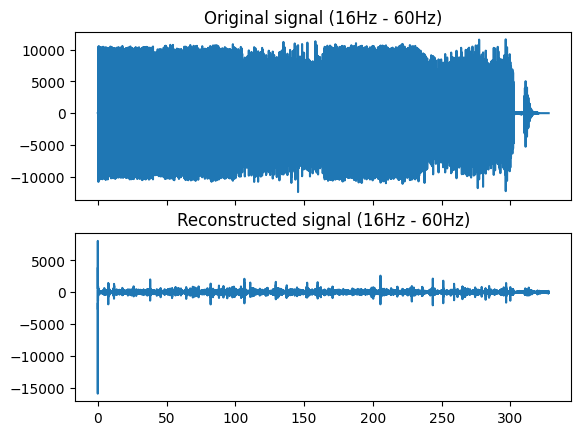

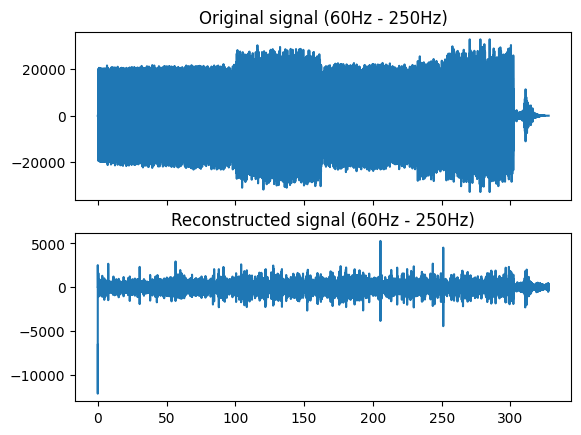

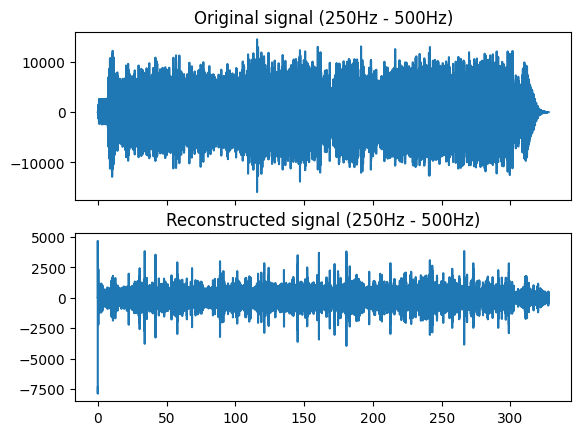

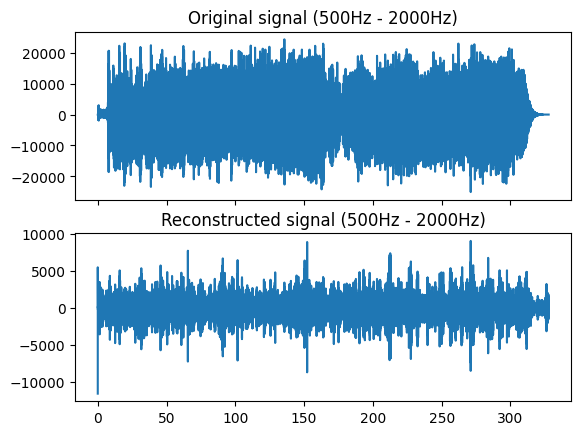

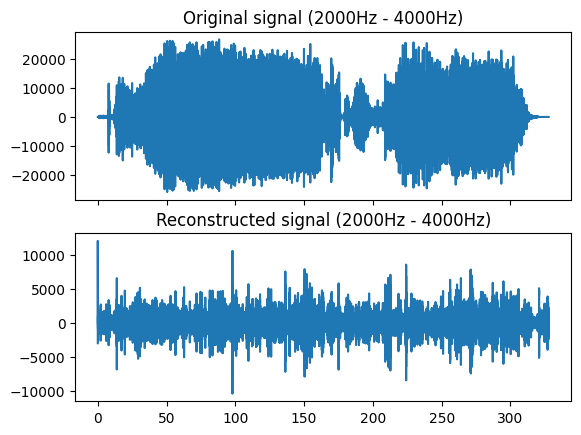

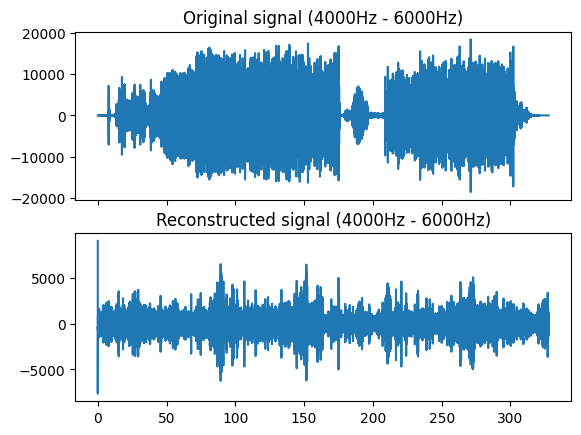

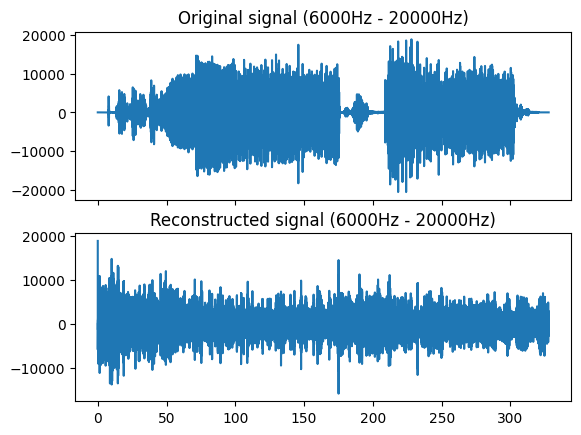

In [22]:
time = np.arange(n_samples) / float(sample_rate)

original_signals = []
reconstructed_signals = []

for freq in AF:
    
    b, a = obtain_filters(sample_rate, AF[freq], N = 3)
    
    filtered_original_signal_sfq = filter_signal(b, a, original_signal) # sfq = sub frequencies
    filtered_reconstructed_signal_sfq = filter_signal(b, a, reconstructed_signal) # sfq = sub frequencies
    
    original_signals.append(filtered_original_signal_sfq)
    reconstructed_signals.append(filtered_reconstructed_signal_sfq)
    
    fig, (ax_orig, ax_filt) = plt.subplots(2, 1, sharex=True)
    ax_orig.plot(time, filtered_original_signal_sfq)
    ax_orig.set_title(f'Original signal ({AF[freq][0]}Hz - {AF[freq][1]}Hz)')
    ax_filt.plot(time, filtered_reconstructed_signal_sfq)
    ax_filt.set_title(f'Reconstructed signal ({AF[freq][0]}Hz - {AF[freq][1]}Hz)')
    plt.show()

We could even save the diferent group of frequencies to listen to them.

In [34]:
for index, key in enumerate(AF):
    print("Frequency range in Herzs:", AF[key])
    print("Saving: RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_" + key)
    write_wav("RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_" + key, sample_rate, reconstructed_signals[index], output_dir_name = "OUTPUT_4")
    print("---")

Frequency range in Herzs: [16, 60]
Saving: RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_sub_bass
---
Frequency range in Herzs: [60, 250]
Saving: RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_bass
---
Frequency range in Herzs: [250, 500]
Saving: RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_low_mids
---
Frequency range in Herzs: [500, 2000]
Saving: RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_mids
---
Frequency range in Herzs: [2000, 4000]
Saving: RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_high_mids
---
Frequency range in Herzs: [4000, 6000]
Saving: RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_presence
---
Frequency range in Herzs: [6000, 20000]
Saving: RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_brillance
---


In [35]:
correlations = []
for i in range(len(original_signals)):
    correlations.append(correlation_normalized(original_signals[i], reconstructed_signals[i]))

By sorting the frequency bands from the ones that have better correlation to worst, we can see where the information is being lost more:

In [36]:
correlations_list = [i[0] for i in correlations]
correlations_array = np.array(correlations_list)
correlations_array[np.isnan(correlations_array)] = 0

best_to_worst_freq = list(correlations_array.argsort()[::-1])
keys_list = np.array(list(AF.keys()))

print(correlations_array[best_to_worst_freq])
print("Frequencies ordered from less losse to more losse: ", keys_list[best_to_worst_freq])
print("Mean correlation: ", correlations_array[:].mean())

[0.58714693 0.54429491 0.49402895 0.46709932 0.4493735  0.34798529
 0.26192198]
Frequencies ordered from less losse to more losse:  ['low_mids' 'mids' 'bass' 'presence' 'high_mids' 'brillance' 'sub_bass']
Mean correlation:  0.4502644124166696


<br>
It results interesting to notice that the first two group of frequencies still maintain more than the half of the original information. Anyway, we can even save just a few groups of frequencies ommiting the last ones that have worse correlation:

In [37]:
# Select the first and third arrays
original_signals_ordered = [original_signals[i] for i in best_to_worst_freq]
reconstructed_signals_ordered = [reconstructed_signals[i] for i in best_to_worst_freq]

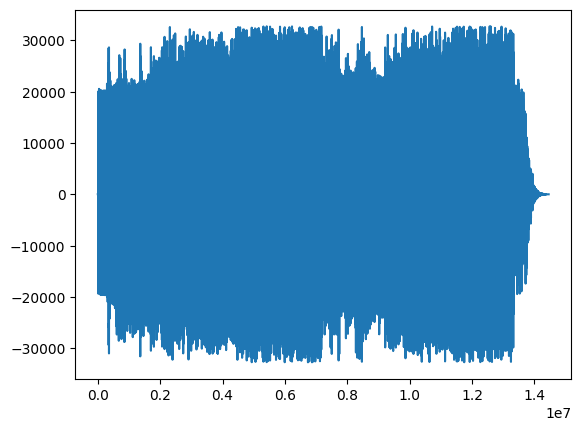

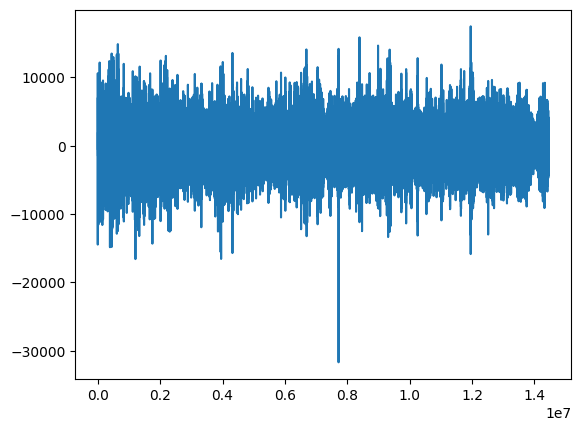

In [38]:
# The Original signal AND The Reconstruced signal simplified (Without Brillance and Sub Bass frequencies)
original_simplified = None
reconstructed_simplified = None

for i in (correlations_array.argsort()[::-1][:5]):
    if original_simplified is None:
        original_simplified = original_signals_ordered[i]
        reconstructed_simplified = reconstructed_signals_ordered[i]
    else:
        original_simplified += original_signals_ordered[i]
        reconstructed_simplified += reconstructed_signals_ordered[i]
        
plt.plot(original_simplified)
plt.show()
plt.plot(reconstructed_simplified)
plt.show()

In [39]:
corr_reconstructed_simplified = correlation_normalized(original_signal, reconstructed_simplified)
corr_reconstructed_simplified

array([0.26584284])

To finish, let's save this reconstructed and simplified audio:

In [40]:
write_wav("RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY_SIMPLIFIED", sample_rate, reconstructed_simplified, output_dir_name = "OUTPUT_4")